# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }

plt.rcParams.update(params)

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
from pandas import json_normalize

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

from bs4 import BeautifulSoup
import unicodedata

import logging
import re
import copy
import os
import sys
import json
from datetime import datetime
from collections import Counter
import string
import glob
import ast
from tqdm.notebook import tqdm
import xmltodict

from tabulate import tabulate

from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report, f1_score, matthews_corrcoef

import lightgbm as lgb

from transformers import pipeline

TITLE_SIZE = 24
TITLE_PAD = 20

DEFAULT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# Comparing results quantitatively
---

Until now I evaluated all approaches by themselves, mostly qualitatively and by manual inspection, e.g. by looking at selected examples. This already brought a lot of insight about how useful each of the different techniques are towards our goal of improving search and discovery of podcasts. 

**In this notebook I'd like to add a quantitative perspective and compare all models with the same success metric.** I do not have an exact ground truth at hand that precisely represents the goal of the project. Instead I will use a proxy metric and measure the performance of the model by their ability to predict the primary genre given by the creator. I will evaluate this by either using the sample vectors / embeddings I have derived from the models (LDA, Doc2Vec, Top2Vec) and use a classifier for prediction. Or I will predict with the model directly (Hugging Face Zero Shot). 

**I choose the F1 score as the metric for evaluation.** It's the harmonic mean of the precision and recall of the model's predictions. 

We already have seen in EDA, that we have a lot of unique primary genres (110 to be exact). We also know that the data set is unbalanced in regard to that label – the label counts range from 1 to 354. **I therefore will use a subset of the data with the 12 most common labels to achieve a more sensible and balanced label distribution.** I will use the **weighted F1 score** to account for the inbalance that will still be left in this subset of data.

# Load and prepare data

I load and prepare the data again as we have done in the previous notebooks.

In [2]:
df = pd.read_parquet("_data/podcasts_cleaned.parq")

# Remove all podcast that weren't updated after 2018.
df.releaseDate = pd.to_datetime(df.releaseDate)
to_drop = df[df.releaseDate.dt.year<2019].index
df.drop(to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)

**The label distribution for these top 12 genres still is quite inbalanced.** There are almost 3 times the samples for `Gesellschaft und Kultur` as there are for `Sport`.

In [3]:
top_n = 12
sample_size = df.primary_genre.value_counts()[:top_n].sum()
genre_subset = df.primary_genre.value_counts()[:top_n].index
print(f"There are {sample_size:,.0f} podcasts with the {top_n} most common labels for primary genre in the data set.\n")
display(df.primary_genre.value_counts()[:top_n])

There are 2,175 podcasts with the 12 most common labels for primary genre in the data set.



Gesellschaft und Kultur    354
Comedy                     208
Selbstverwirklichung       188
Wirtschaft                 179
Christentum                166
Technologie                165
Mentale Gesundheit         161
Karriere                   161
Bildung                    159
Fußball                    155
Nachrichten                145
Sport                      134
Name: primary_genre, dtype: int64

I create a subset of the data by keeping only podcasts of these top 12 primary genres.

In [4]:
# Create subset with only the samples that have a top n primary genre
df_sub = df[df.primary_genre.isin(genre_subset)]

# Predict from vectors

I now load the vectors that I have saved for later use in each of the previous modelling steps.

In [5]:
vectors_lda = pd.read_parquet("_models/vectors_lda.parq")
vectors_lda = vectors_lda.loc[df_sub.index]

vectors_doc2vec = pd.read_parquet("_models/vectors_doc2vec.parq")
vectors_doc2vec = vectors_doc2vec.loc[df_sub.index]

vectors_top2vec = pd.read_parquet("_models/vectors_top2vec.parq")
vectors_top2vec = vectors_top2vec.loc[df_sub.index]

## Baseline

As a first baseline I train 7 classifiers (and a dummy classifier) and measure their performance by crossvalidation.

In [6]:
classifiers = [
    DummyClassifier(strategy="stratified"),
    LogisticRegression(max_iter=1e4, class_weight="balanced", n_jobs=-1),
    RidgeClassifier(max_iter=1e4, class_weight="balanced"),
    KNeighborsClassifier(n_jobs=-1),
    LinearDiscriminantAnalysis(), 
    SVC(kernel="rbf", class_weight="balanced"),
    RandomForestClassifier(class_weight="balanced", n_jobs=-1),
    lgb.LGBMClassifier(objective="multiclass", class_weight="balanced", n_jobs=-1)
]

In [7]:
%%time
vector_set_names = ["lda", "doc2vec", "top2vec"]
vector_sets = [vectors_lda, vectors_doc2vec, vectors_top2vec] 
baseline_results = []

for vector_set_name, vector_set in tqdm(zip(vector_set_names, vector_sets)):
    for clf in classifiers:
        score = np.mean(cross_val_score(clf, 
                                        vector_set, 
                                        df_sub.primary_genre, 
                                        scoring="f1_weighted", 
                                       ))
        
        baseline_results.append((vector_set_name, clf, np.round(score, 4), ))

0it [00:00, ?it/s]

CPU times: user 5min 58s, sys: 1min 21s, total: 7min 20s
Wall time: 1min 21s


- **Top2Vec and Doc2Vec vectors yield the best results** as training data and clearly outperfom the LDA vectors.
- **SVC yields the best F1 score of 0.653** with the Top2Vec vectors.
- **Logistic regression follows closely with 0.643**.

In [8]:
baseline_results = pd.DataFrame(baseline_results)
baseline_results.columns = ["vector_set", "clf", "score"]
baseline_results.clf = baseline_results.clf.apply(lambda x: str(x).split("(")[0])
display(baseline_results.sort_values("score", ascending=False).reset_index(drop=True))

,vector_set,clf,score
0,top2vec,SVC,0.6531
1,top2vec,LogisticRegression,0.6430
2,doc2vec,SVC,0.6357
3,top2vec,LinearDiscriminantAnalysis,0.6274
4,top2vec,RidgeClassifier,0.6131
5,doc2vec,LinearDiscriminantAnalysis,0.6102
6,doc2vec,LGBMClassifier,0.6071
7,top2vec,KNeighborsClassifier,0.5684
8,doc2vec,RidgeClassifier,0.5670
9,doc2vec,RandomForestClassifier,0.5649


**For the two best performing classifiers I try to find optimal hyperparameters**, particularly regarding the regularization strength (hyperparameter `C`) by random search with cross validation.

- SVC improves only slightly with a lesser regularization strength of ~1.18 (default 1). We achieve an **F1 score of 0.654.**
- The optimized hyperparameter regularization strength for Logistic Regression is ~0.58 (default 1). The **F1 score improves slightly from to 0.645.**

In [55]:
def random_search_hyperparams(clf, search_space, X, y):
    rnd_search = RandomizedSearchCV(clf, 
                                    search_space, 
                                    n_iter=250,
                                    scoring="f1_weighted",
                                    random_state=42, 
                                    verbose=0, 
                                    n_jobs=-1)

    rnd_search.fit(X, y)
    print(f"Best F1 score from RandomSearchCV: {rnd_search.best_score_:.3f}")
    print("Best found hyperparameters:")
    print(rnd_search.best_params_)

In [12]:
%%time
clf = SVC(kernel="rbf", class_weight="balanced")
search_space = dict(C=np.logspace(-0.1, 2, 50), 
                    gamma=np.logspace(-5, 1, 50))
random_search_hyperparams(clf, search_space, vectors_top2vec, df_sub.primary_genre)

Best F1 score from RandomSearchCV: 0.654
Best found hyperparameters:
{'gamma': 0.33932217718953295, 'C': 1.1787686347935873}
CPU times: user 4.24 s, sys: 434 ms, total: 4.68 s
Wall time: 3min 31s


In [13]:
%%time
clf = LogisticRegression(max_iter=1e4, class_weight="balanced", n_jobs=-1)
search_space = dict(C=np.logspace(-0.5, 0.5, 50))
random_search_hyperparams(clf, search_space, vectors_top2vec, df_sub.primary_genre)

Best F1 score from RandomSearchCV: 0.645
Best found hyperparameters:
{'C': 0.5825136712468926}
CPU times: user 426 ms, sys: 53.5 ms, total: 479 ms
Wall time: 7.37 s


**Can we improve the F1 score by reducing the dimensionality of the Top2Vec vectors? As it turns out, we can.** 

I use PCA on the vectors, train a SVC model for every 10th component count up to the original dimensionality of 300 and retrieve the F1 score with cross validation. **The best result is 0.661 with 120 components.**

In [58]:
%%time
results = []
rng = range(10, 310, 10)
for n in rng:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(vectors_top2vec)

    clf = SVC(kernel="rbf", class_weight="balanced")
    score = np.mean(cross_val_score(clf, X_pca, 
                                    df_sub.primary_genre, 
                                    scoring="f1_weighted"))
    results.append(score)

CPU times: user 1min 41s, sys: 18.6 s, total: 2min
Wall time: 1min 11s


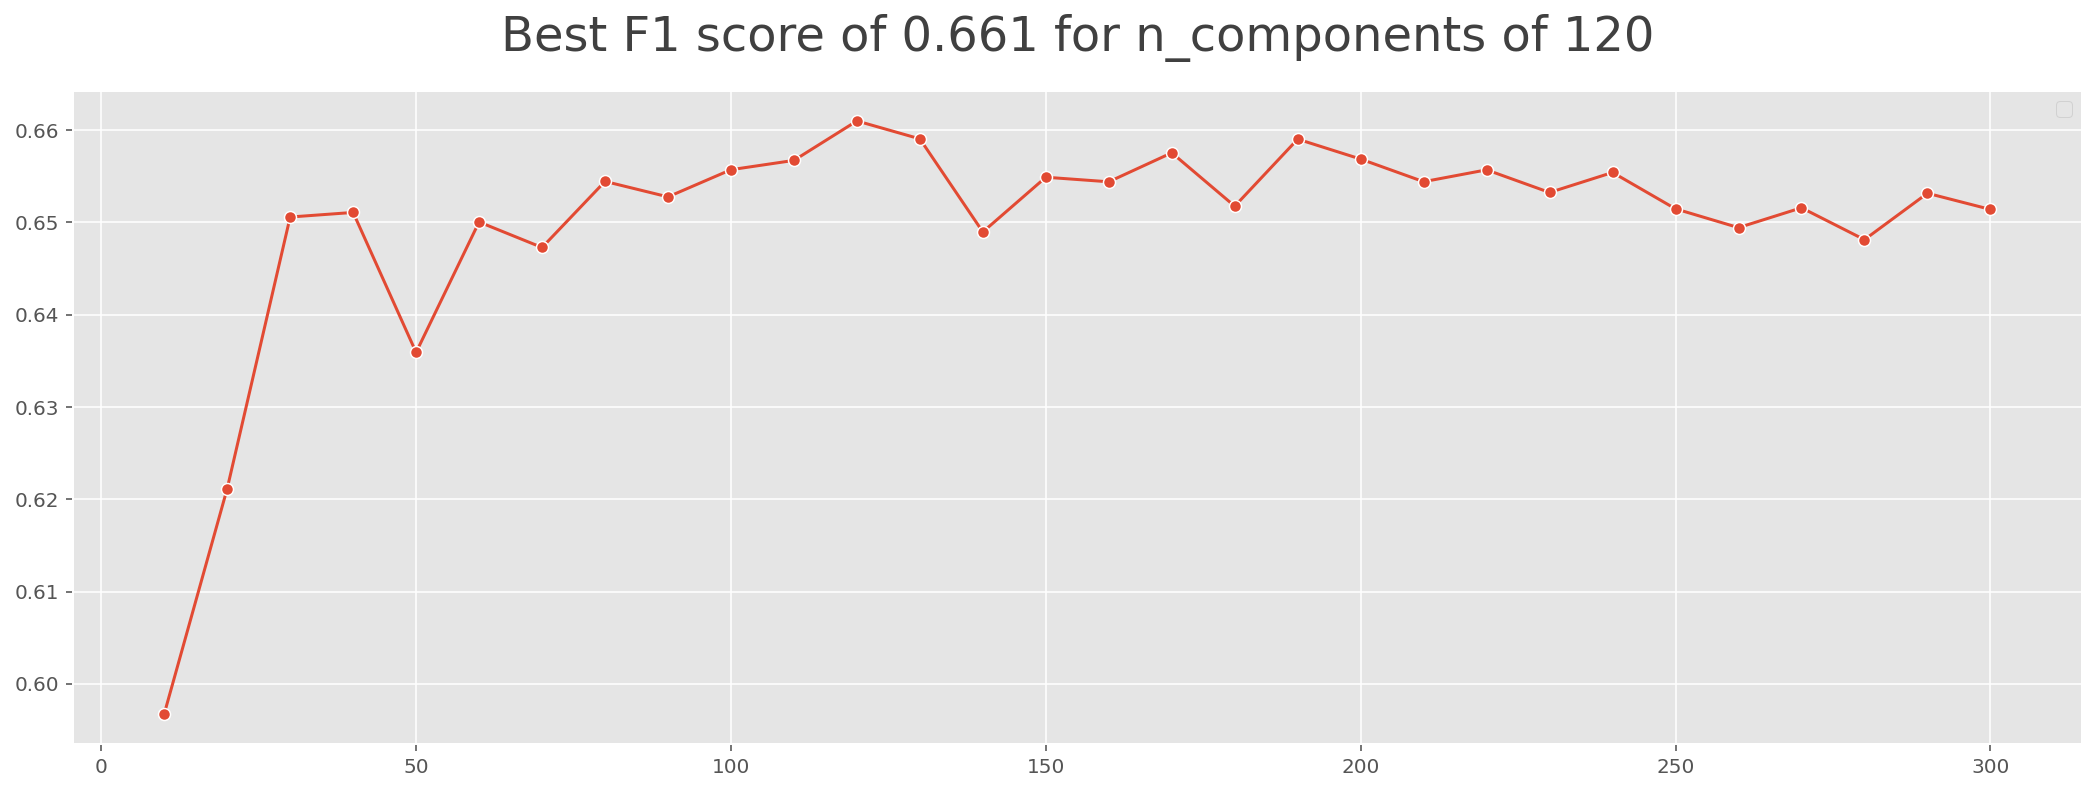

In [59]:
tmp = pd.DataFrame(results, index=rng, columns=["f1_weighted"])

best_score = tmp.f1_weighted.max()
best_n_components = tmp.f1_weighted.idxmax()

sns.lineplot(data=tmp, markers="o")
plt.title(f"Best F1 score of {np.round(best_score, 3)} for n_components of {best_n_components}", 
          size=TITLE_SIZE, pad=TITLE_PAD)
plt.legend("")
plt.show()

It is somewhat suprising that the tree based classifiers aren't performing up to par with SVC and Logistic Regression. Let's try to improve the LGBM model by training with less components.

- Reducing the Top2Vec vectors from 300 to 100 components already yields an substantial improvement of the LightGBM performance of 0.622 (from 0.607).

In [61]:
%%time
results_lgb = []
rng = range(50, 130, 10)
for n in tqdm(rng):
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(vectors_top2vec)

    clf = lgb.LGBMClassifier(objective="multiclass", 
                             class_weight="balanced", 
                             n_jobs=-1)
    
    score = np.mean(cross_val_score(clf, X_pca, 
                                    df_sub.primary_genre, 
                                    scoring="f1_weighted"))
    results_lgb.append(score)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 8min 35s, sys: 1min 33s, total: 10min 8s
Wall time: 1min 21s


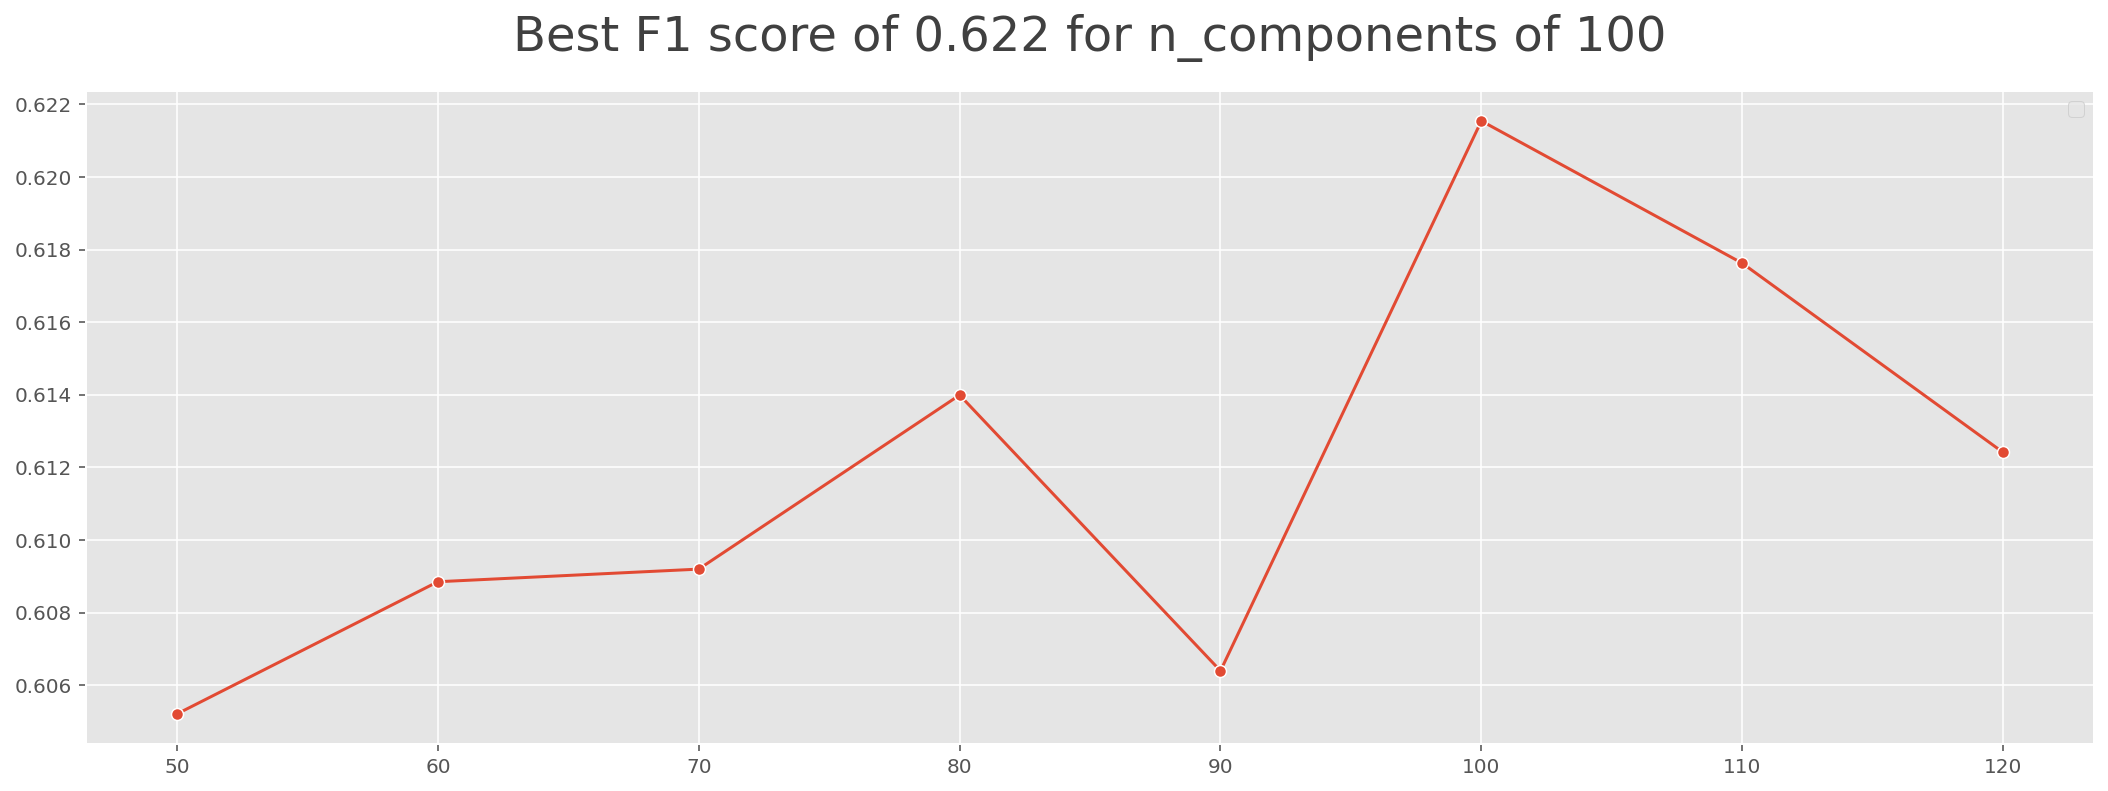

In [62]:
tmp = pd.DataFrame(results_lgb, index=rng, columns=["f1_weighted"])

best_score = tmp.f1_weighted.max()
best_n_components = tmp.f1_weighted.idxmax()

sns.lineplot(data=tmp, markers="o")
plt.title(f"Best F1 score of {np.round(best_score, 3)} for n_components of {best_n_components}", 
          size=TITLE_SIZE, pad=TITLE_PAD)
plt.legend("")
plt.show()

By random searching better hyperparameters with the PCA'd vectors we achieve a slightly worse F1 score of 0.622. 

In [71]:
%%time
clf = lgb.LGBMClassifier(objective="multiclass", class_weight="balanced", n_jobs=-1)
search_space = dict(n_estimators=range(200, 2200, 50), 
                    learning_rate=np.logspace(-2, -1, 21))

pca = PCA(n_components=100)
X_pca = pca.fit_transform(vectors_top2vec)
random_search_hyperparams(clf, search_space, X_pca, df_sub.primary_genre)

Best F1 score from RandomSearchCV: 0.620
Best found hyperparameters:
{'n_estimators': 2000, 'learning_rate': 0.015848931924611134}
CPU times: user 2min 47s, sys: 42.5 s, total: 3min 30s
Wall time: 1h 35min 31s


# Predict with Zero Shot

## Prepare the data
First I prepare the data as before for zero shot classification with the Hugging Face model.

In [28]:
def join_text_columns(data):
    text = []
    for row in data.values:
        if type(row) is str:
            text.append(row)
        elif isinstance(row, (np.ndarray, list)):
            text.append(" ".join(row))
        else:
            assert row is None
            text.append("")
            continue
    return " ".join(text)    

In [29]:
podcast_columns = ['artistName', 'title', 'subtitle', 'summary', "tags", 'ep_subtitles', 'ep_summaries', 'ep_contents']
df_pod = df[podcast_columns].apply(join_text_columns, axis=1) 

In [30]:
RE_ASCII = re.compile(r"[^A-Za-zÀ-žäüöÄÜÖ.!? ]", re.IGNORECASE)
REMOVE_LESS_THAN = 2

def clean_text(text, remove_name=False):
    
    # Reduce to 1000 words. We only need 512 tokens for Hugging Face models.
    text = " ".join(text.split(" ")[:1500])
    
    # Strip HTML tags.
    text = BeautifulSoup(text, "lxml").get_text()
    
    # Normalize form of unicode strings.
    # https://docs.python.org/3/library/unicodedata.html#unicodedata.normalize
    # text = unicodedata.normalize("NFKD", text)
    
    # Keep only ASCII + European Chars and whitespace
    text = re.sub(RE_ASCII, " ", text)
   
    # Remove links.
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'www.\S+', ' ', text)
    
    # Remove all words less than 2 digits long.
    text = " ".join([token for token in text.split(" ") if len(token)>REMOVE_LESS_THAN])
    
    if remove_name==True:
        # Remove persons names. 
        doc = nlp(text)
        text = [token.text for token in doc.ents if token.label_!="PER"]
        text = " ".join(text)
    
    return text

In [31]:
%%time
df_pod = df_pod.apply(clean_text)
df["text"] = df_pod

CPU times: user 9.6 s, sys: 736 ms, total: 10.3 s
Wall time: 10.3 s


In [32]:
# Reduce to 512 words to speed up processing.
# Again – we only need 512 tokens. 
df_pod = df_pod.apply(lambda x: " ".join(x.split(" ")[:512]))

In [33]:
df["text"] = df_pod
df["word_count"] = df.text.apply(lambda x: len(x.split()))

df_sub = df[df.primary_genre.isin(genre_subset)]

In [34]:
classifier = pipeline("zero-shot-classification", model="_data/_huggingface/")

## Sanity check with some samples

By trying some samples I observe:
- Several predictions are accurate.
- Some predictions are wrong but sensible: e.g. `Fussball` is classified as `Sport` and `Gesellschaft und Kultur` as `Bildung`.
- When the prediction is wrong the true label at least ranks among the top labels (which won't improve the F1 score but is interesting to see nonetheless).
- Some wrong predictions seem to be more sensible than the actual label: e.g. `Horbach Berufsstart Podcast` is classified as `Karriere` instead of `Selbstverwirklichung`.
- Prediction with 12 rather than 2 candidate labels takes around 9 secs inference per sample. Prediction on the whole subset of 2k samples takes around 5 hours of processing.

In [68]:
template = "In diesem Text geht es um {}."
labels = genre_subset

In [94]:
def show_result(text, result):
    print(f"Text input: «{text}»")
    display(list(zip(result["labels"][:5], [np.round(x, 2) for x in result["scores"][:5]])))
    print()

In [95]:
text = 'Ein Moskauer Gericht hat Bußgelder in Millionenhöhe gegen Google und Facebook verhängt.'
result = classifier(text, labels, hypothesis_template=template)
show_result(text, result)

text = 'Das ist das Witzigste was ich je gesehen habe. Ich musste sehr lachen über diesen Gag.'
result = classifier(text, labels, hypothesis_template=template)
show_result(text, result)

Text input: «Ein Moskauer Gericht hat Bußgelder in Millionenhöhe gegen Google und Facebook verhängt.»


[('Nachrichten', 0.29),
 ('Wirtschaft', 0.21),
 ('Technologie', 0.15),
 ('Selbstverwirklichung', 0.06),
 ('Mentale Gesundheit', 0.06)]


Text input: «Das ist das Witzigste was ich je gesehen habe. Ich musste sehr lachen über diesen Gag.»


[('Comedy', 0.47),
 ('Nachrichten', 0.07),
 ('Mentale Gesundheit', 0.07),
 ('Bildung', 0.06),
 ('Selbstverwirklichung', 0.06)]

In [98]:
for primary_genre in genre_subset:
    text = df_sub[df_sub.primary_genre==primary_genre].text.sample(1, random_state=42).values
    result = classifier(text, labels, hypothesis_template="In diesem Text geht es um {}.")
    print(primary_genre)
    show_result(text[0][:200], result)

Gesellschaft und Kultur
Text input: «Verlag Stumpf Kossendey GmbH EINSATZ Der Podcast für den Katastrophenschutz Von Katastrophenschützern für Katastrophenschützer EINSATZ Der Podcast berichtet monatlich unabhängig über Entwicklungen Ber»


[('Bildung', 0.29),
 ('Nachrichten', 0.16),
 ('Gesellschaft und Kultur', 0.15),
 ('Mentale Gesundheit', 0.09),
 ('Christentum', 0.07)]


Comedy
Text input: «Joel und Kian Der Podcast mit Joel und Kian. diesem Podcast begleiten wir euch ein wenig durch den Alltag und versuchen euch ein wenig Freude und Unterhaltung geben. Wir sind zwar nicht vergleichbar m»


[('Selbstverwirklichung', 0.32),
 ('Comedy', 0.17),
 ('Mentale Gesundheit', 0.11),
 ('Bildung', 0.11),
 ('Gesellschaft und Kultur', 0.06)]


Selbstverwirklichung
Text input: «HORBACH Wirtschaftsberatung GmbH Let schnack! Der HORBACH Podcast rund Zukunft Berufsstart auch immer Leben gerade stehst Wir von HORBACH helfen dir deine persönlichen Potenziale entfalten und unterst»


[('Karriere', 0.26),
 ('Selbstverwirklichung', 0.22),
 ('Bildung', 0.12),
 ('Wirtschaft', 0.11),
 ('Gesellschaft und Kultur', 0.07)]


Wirtschaft
Text input: «Sebastian Vogg Niels Stuck Online Marketing Podcast Der ehrliche Podcast für fortgeschrittene Online Marketer hast die Schnauze voll von scammy Online Marketing Gurus die dir oberflächliche Hype Strat»


[('Selbstverwirklichung', 0.19),
 ('Bildung', 0.18),
 ('Karriere', 0.16),
 ('Mentale Gesundheit', 0.09),
 ('Nachrichten', 0.08)]


Christentum
Text input: «Evangelisch freikirchliche Gemeinde Döhrener Turm Predigten aus der Gemeinde Döhrener Turm Christusorientiert. Menschenfreundlich. Weltoffen. suchst was Echtes? Hier bist richtig. Bei uns gibt offene »


[('Christentum', 0.53),
 ('Nachrichten', 0.12),
 ('Mentale Gesundheit', 0.07),
 ('Bildung', 0.06),
 ('Gesellschaft und Kultur', 0.05)]


Technologie
Text input: «Patrick Gaißert Robert Schmitz Stefan Kassal Coffee Let talk about Mobile and Realities Podcast Coffee sprechen wir über spannende technische Neuerung Tricks Kniffe und Anekdoten aus unserem Arbeitsal»


[('Technologie', 0.29),
 ('Nachrichten', 0.14),
 ('Karriere', 0.12),
 ('Bildung', 0.11),
 ('Selbstverwirklichung', 0.08)]


Mentale Gesundheit
Text input: «Hamburger Hospiz Hamburger Hospiz e.V. Hospiz drückt eine solidarisch mitmenschliche Haltung Sterbenden und Angehörigen gegenüber aus die Selbstbestimmung und Lebensqualität den Mittelpunkt stellt. Un»


[('Bildung', 0.23),
 ('Mentale Gesundheit', 0.23),
 ('Selbstverwirklichung', 0.17),
 ('Nachrichten', 0.09),
 ('Gesellschaft und Kultur', 0.08)]


Karriere
Text input: «Sina Töpfer bist. Laute Impulse für Deinen Kanzlei Alltag. Die Themen die als Bodensatz aus unzähligen Recruiting Prozessen übrigbleiben und über die wir dringend sprechen und diskutieren müssen mache»


[('Karriere', 0.22),
 ('Wirtschaft', 0.12),
 ('Nachrichten', 0.12),
 ('Selbstverwirklichung', 0.11),
 ('Bildung', 0.09)]


Bildung
Text input: «Gesche und Jörn Schaar Natürlich.SH Gesche und Jörn erklären den Norden. Dieser Podcast ist ein bisschen wie Die Sendung mit der Maus für Große. Wir ziehen Gummistiefeln durch das Land der Horizonte. »


[('Gesellschaft und Kultur', 0.15),
 ('Mentale Gesundheit', 0.12),
 ('Nachrichten', 0.1),
 ('Bildung', 0.1),
 ('Sport', 0.08)]


Fußball
Text input: «Bayern München Bayern Podcast Der Bayern Podcast bringt euren Herzensverein euer Wohnzimmer eure Kopfhörer euer Ohr. Das neue Audio Format bietet hintergründige authentische und unterhaltende Einblick»


[('Sport', 0.22),
 ('Karriere', 0.21),
 ('Fußball', 0.15),
 ('Gesellschaft und Kultur', 0.14),
 ('Selbstverwirklichung', 0.08)]


Nachrichten
Text input: «Journal Jounal Pfeffers Portal für Public Relations. Größtes news Oktober dieser Episode des Journal Auch letzten Journal Podcast des Jahres sch Aus Anlass der Internationalen Tourismus Börse Corona h»


[('Nachrichten', 0.2),
 ('Gesellschaft und Kultur', 0.14),
 ('Karriere', 0.12),
 ('Wirtschaft', 0.09),
 ('Bildung', 0.08)]


Sport
Text input: «Hüttenberg Gude wie? Der TVH Podkäs. Gude. Wer jetzt denkt dass die beim TVH nicht einmal der deutschen Sprache mächtig sind irrt sich. Wer Hüttenberg kennt weiß wiederum auch dass wir das Handkäsedor»


[('Sport', 0.37),
 ('Fußball', 0.16),
 ('Karriere', 0.1),
 ('Nachrichten', 0.09),
 ('Selbstverwirklichung', 0.06)]

## Classify on full data set

I now retrieve predictions on the whole subset of podcast samples. 

In [35]:
def get_zero_shot(data, labels, template):
    predictions = []
    for text in tqdm(data):
        res = classifier(text, labels, hypothesis_template=template)
        predictions.append(res["labels"][0])
    return predictions

In [71]:
y_preds = get_zero_shot(df_sub.text, 
                       labels, 
                       "In diesem Text geht es um {}.")

In [50]:
# # Saving the results to be able to reload later.
# pd.DataFrame(y_preds).to_csv("_data/zeroshot_top12.csv")
y_preds = pd.read_csv("_data/zeroshot_top12.csv", index_col=0)
y_preds = [x[0] for x in y_preds.values]

The scoring of 0.56 is significantly worse than that of logistic regression with the Top2Vec vectors. However, zero shot classification ranks #10 in the list of baselines the we created above.

In [55]:
y_true = df_sub.primary_genre
score = f1_score(y_true, y_preds, average="weighted")
print(f"Zero shot classification yields an F1 score of: {np.round(score, 4)}")

Zero shot classification yields an F1 score of: 0.5602


By looking at the various classification metrics and the confusion matrix I observe:
- `Christentum` is the class label with the highest f1 score of 0.88 and a near perfect precision of 0.96.
- `Wirtschaft` has the lowest F1 score and seems to be the hardest label to predict. The precision is quite good but the recall really bad. The label is often misclassified as `Karriere`, `Selbstverwirklichung` or `Technologie` – topics that are quite related. 
- A lot of the misclassifications make sense. E.g. `Fussball` again is mostly classified as `Sport` – which it is. Or almost 20% of `Karriere` podcasts are labeled as `Selbstverwirklichung`. 

In [52]:
print(classification_report(y_true, y_preds, zero_division=False))

                         precision    recall  f1-score   support

                Bildung       0.54      0.37      0.44       159
            Christentum       0.96      0.82      0.88       166
                 Comedy       0.92      0.47      0.62       208
                Fußball       0.84      0.33      0.47       155
Gesellschaft und Kultur       0.66      0.58      0.62       354
               Karriere       0.48      0.61      0.54       161
     Mentale Gesundheit       0.58      0.61      0.60       161
            Nachrichten       0.41      0.73      0.52       145
   Selbstverwirklichung       0.36      0.53      0.43       188
                  Sport       0.43      0.86      0.57       134
            Technologie       0.66      0.79      0.72       165
             Wirtschaft       0.53      0.17      0.26       179

               accuracy                           0.57      2175
              macro avg       0.61      0.57      0.56      2175
           weighted avg

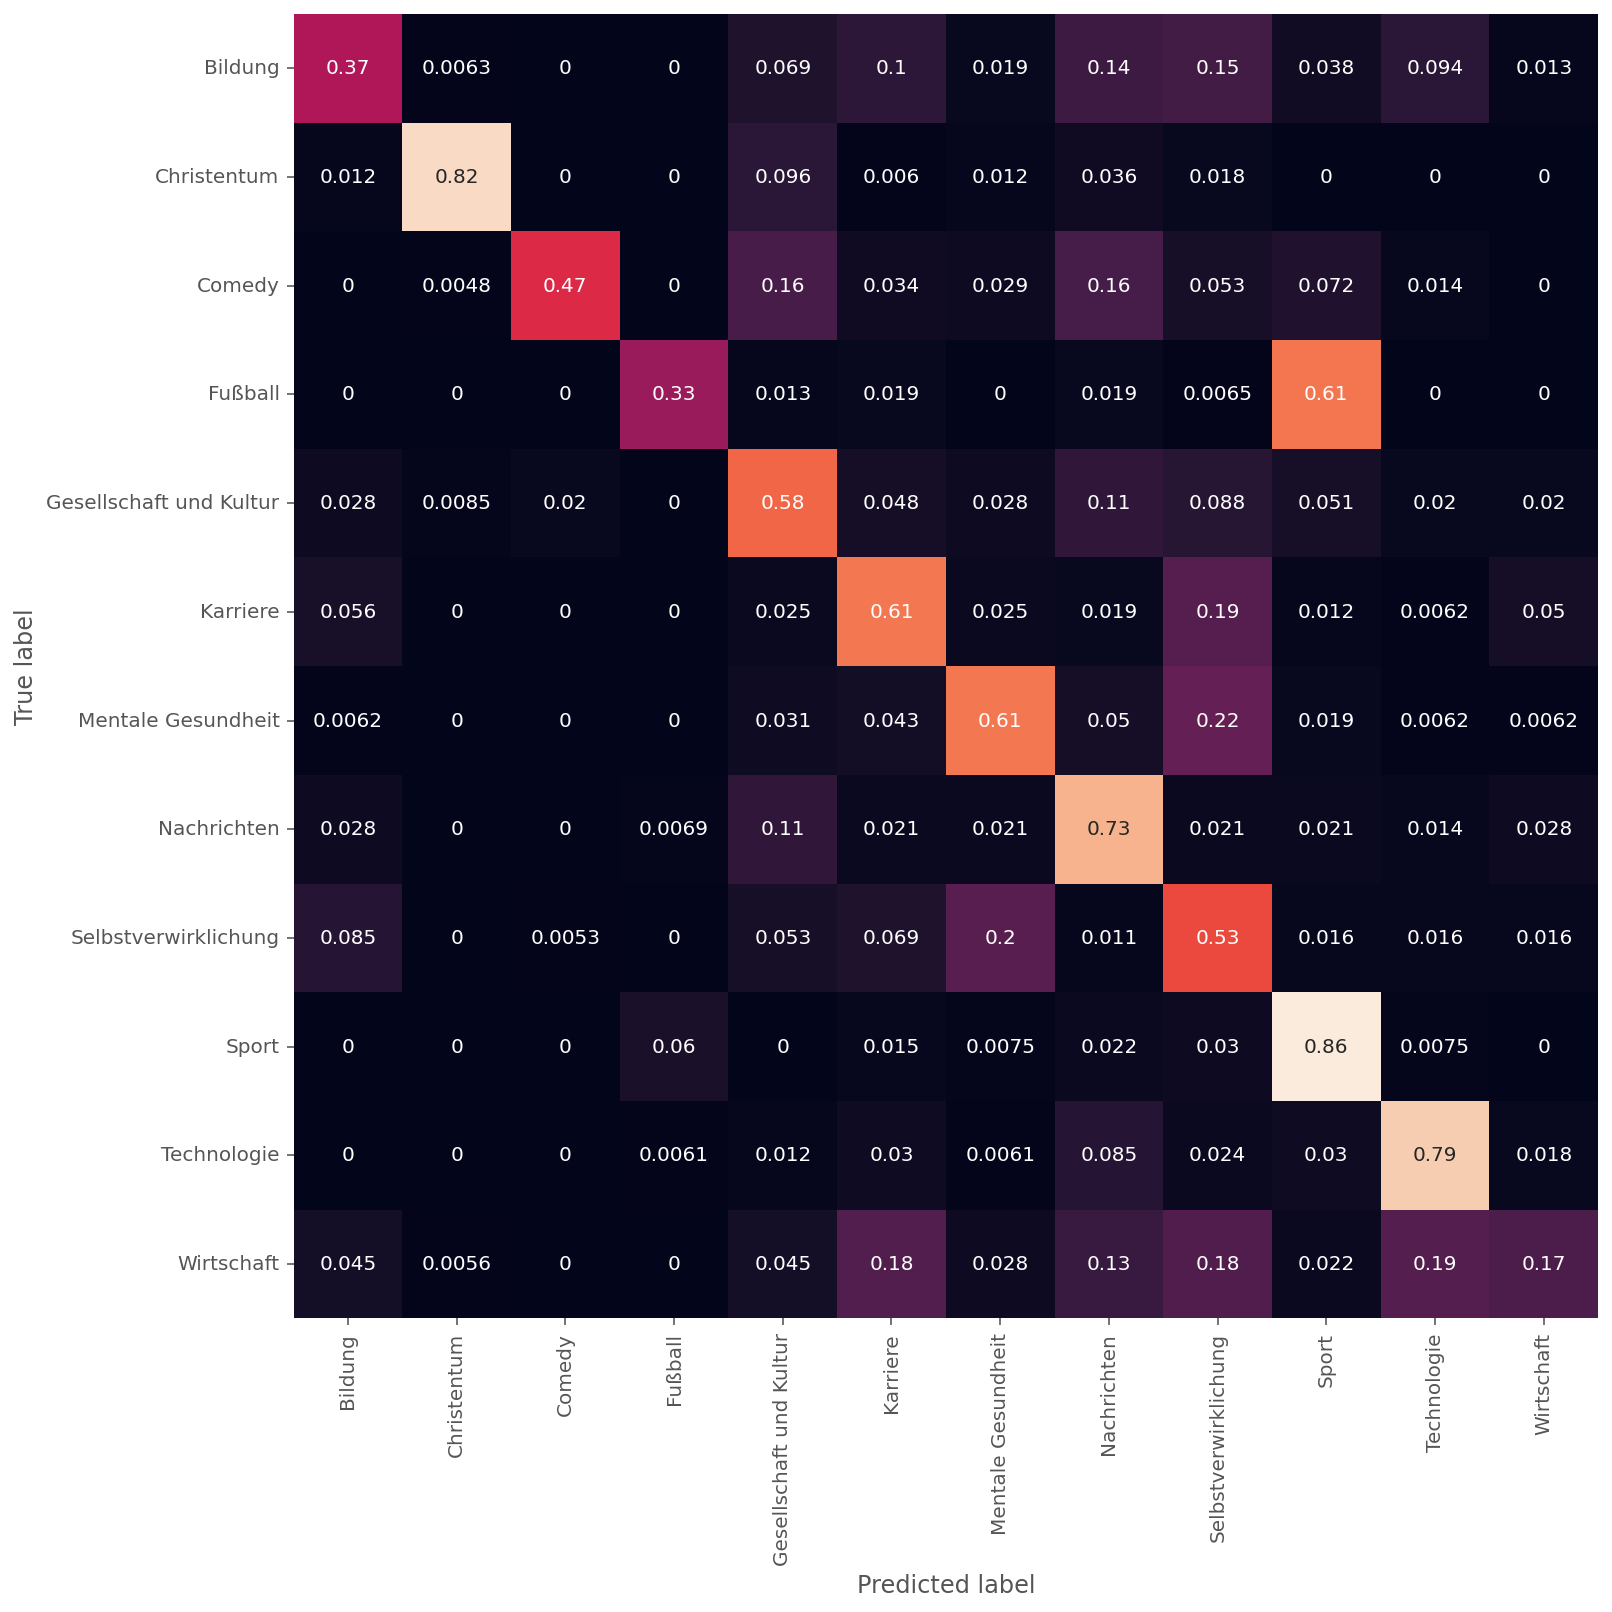

In [64]:
cf_labels = sorted(list(set(y_true)))
cfmtrx = confusion_matrix(y_true, y_preds, labels=cf_labels, normalize="true")
# with pd.option_context('display.float_format', '{:4.2f}'.format):
#     display(pd.DataFrame(cfmtrx, index=cf_labels, columns=cf_labels))    

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cfmtrx, square=True, annot=True, 
            cbar=False,
            xticklabels=cf_labels, 
            yticklabels=cf_labels)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Conclusions

- **All modelling approaches (LDA, Doc2Vec, Top2Vec, zero shot) perform well in regard to this litmus test for model quality.**
- **Top2Vec vectors yield the best F1 score**, zero shot classification the least good. Nonetheless, we achieved very reasonable results with the zero shot model. Even the misclassifications were comprehensible and in some cases arguably closer to reality than the actual labels. 
- **SVC and Logistic regression performed best**. Hyperparameter search only improved the scoring slightly. Reducing the dimensionality of the vectors brought more substantial gains.
- Astonishingly, tree-based models performed less good than the «classic» classifiers. Only LightGBM came close to top results and only with the Top2Vec vectors that were reduced from 300 to 100 dimensions.